In [1]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    normalise_data_chebyshev, 
    get_acf,
    find_index,
    Koopman_correlation_function)
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD
import matplotlib
import plotly.graph_objects as go
from tqdm import tqdm
from LorenzEDMD.utils.paths import get_data_folder_path

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

In [6]:
data_path = get_data_folder_path()
f_name = "edmd.pkl"

with open(data_path / f_name,"rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

#### Fix a degree, regularise and get spectral properties

In [7]:
degree_number = -1
degree = degrees[degree_number] 
edmd_flight_times = EDMDS[degree_number]
edmd : EDMD_CHEB = edmd_flight_times[0] 
print(degree)

15


In [9]:
# Regularisation with TSVDS
tsvd_regulariser = TSVD(rel_threshold=1e-6)
Kreduced = tsvd_regulariser.decompose(edmd)

# Get spectral properties
tsvd_regulariser.get_spectral_properties()
lambdas = np.log(tsvd_regulariser.eigenvalues) / ( lorenz.dt * lorenz.tau * edmd.flight_time)
print(len(lambdas))

259


#### Evaluate correlation functions for Koopman Eigenfunctions

In [11]:
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 2
lorenz_cf_traj.t_span = (0,10000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 2000000/2000000 [00:17<00:00, 113564.91it/s]


In [12]:
PHI_TRAJ = edmd.evaluate_koopman_eigenfunctions_reduced(scaled,tsvd_regulariser)

In [13]:
numbers = [1,3,4,6,8]
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

/Users/niccolo/Desktop/Response_Lorenz_Koopman/.venv/lib/python3.10/site-packages/numpy/_core/_asarray.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


Text(0.5, 0, '$t$')

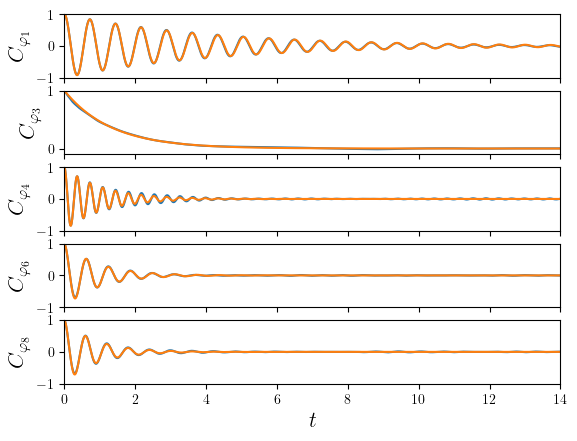

In [14]:
fig , ax = plt.subplots(len(numbers),sharex=True)

for i,number in enumerate(numbers):
    lags, cf = get_acf(PHI_TRAJ[:,number], nlags = nlags,Dt=Dt)
    cf_th = np.real(np.exp(lambdas[number]*lags))
    ax[i].plot(lags,cf/cf[0])
    ax[i].plot(lags,cf_th /cf_th[0] )
    ax[i].set_xlim(0,14)
    
    ax[i].set_ylim(-1,1)
    if i ==1 :
        ax[i].set_ylim(-0.1,1)
    ax[i].set_ylabel(fr"$C_{{ \varphi_{number} }}$",size=16)
ax[-1].set_xlabel("$t$",size=16)    
#fig.savefig("Correlation_function_Koopman_eigenfunctions.png",dpi=600)

(0.0, 15.0)

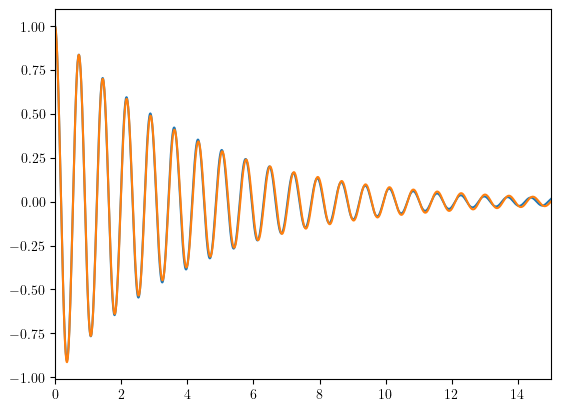

In [15]:
fig , ax = plt.subplots()

number = 1
lags, cf = get_acf(PHI_TRAJ[:,number], nlags = nlags,Dt=Dt)
cf_th = np.real(np.exp(lambdas[number]*lags))
ax.plot(lags,cf/cf[0])
ax.plot(lags,cf_th /cf_th[0] )
ax.set_xlim(0,15)

### Evaluate correlation functions of observables

In [16]:
z_index = (0,0,1)
xy_index = (1,1,0)
selected_index = z_index

In [17]:
index = find_index(edmd.indices,selected_index)
projections_dictionary = np.zeros(len(edmd.indices))
projections_dictionary[index] = 1

In [18]:
# Project in the r-dimensional space
Gr = np.diag(tsvd_regulariser.Sr)
G_koop_r = tsvd_regulariser.reduced_right_eigvecs.T.conj() @ Gr @ tsvd_regulariser.reduced_right_eigvecs
projections_reduced = tsvd_regulariser.Ur.T @ projections_dictionary

# Thresholding on a subset of modes
tau_threshold = -1.5
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]

# Projection onto the subspace spanned by the leading n selected modes
Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
G_koop_n = Vn.T.conj() @ Gr @ Vn
fn =  np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr @ projections_reduced

# Old projection
fnOld = tsvd_regulariser.reduced_left_eigvecs.T.conj() @ projections_reduced

(0.0, 9.0)

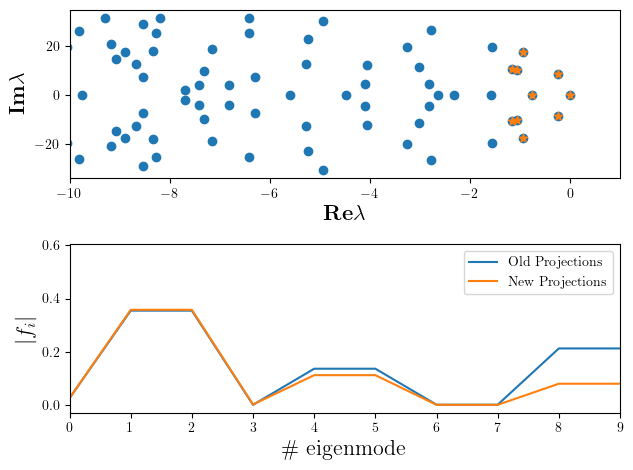

In [19]:
fig, ax = plt.subplots(nrows=2)
ax[0].scatter(np.real(lambdas),np.imag(lambdas))
ax[0].scatter(np.real(lambdas_good), np.imag(lambdas_good),marker="*")
ax[0].set_xlabel(r"$\mathbf{Re}\lambda$",size=16)
ax[0].set_ylabel(r"$\mathbf{Im}\lambda$",size=16)
ax[0].set_xlim(-10,1)

ax[1].plot(np.abs(fn),label="Old Projections")
ax[1].plot(np.abs(fnOld), label = "New Projections")
ax[1].legend()
ax[1].set_xlabel(r"\# eigenmode",size=16)
ax[1].set_ylabel(r"$|f_i|$",size=16)
fig.tight_layout()
ax[1].set_xlim(0,indx[-1])
#fig.savefig("Projections_high.png",dpi=600)

In [20]:
#K_corr_old = lambda t: Koopman_correlation_function(t,G_koop_r,fnOld,fnOld,lambdas,to_include=len(lambdas_good))
K_corr_proj = lambda t: Koopman_correlation_function(t,G_koop_n,fn,fn,lambdas_good )

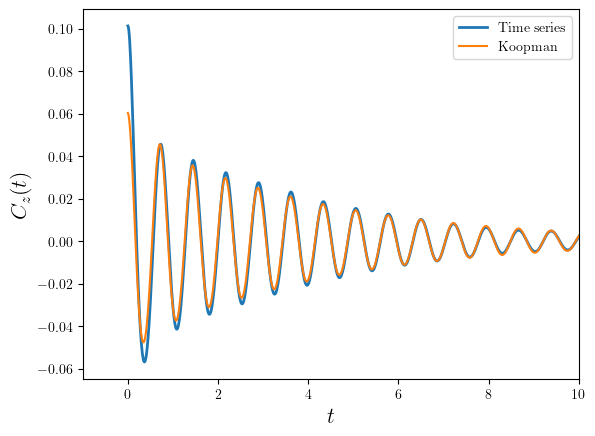

In [21]:
x,y,z = scaled[:,0] , scaled[:,1] , scaled[:,2]
lags, cf = get_acf(z, nlags = nlags,Dt=Dt)
plt.plot(lags,cf  ,label="Time series",linewidth=2)
#plt.plot(lags,np.real( [K_corr_old(lag) for lag in lags])   ,label="Old Koopman")
plt.plot(lags,np.real([K_corr_proj(lag) for lag in lags]), label = "Koopman")

plt.xlim(-1,10)
plt.xlabel(r"$t$",size=16)
plt.ylabel(r"$C_{z}(t)$",size=16)
plt.legend()
#plt.ylim(-0.2,0.2)
#plt.savefig("Correlation_function_z_comparison.png",dpi=600)

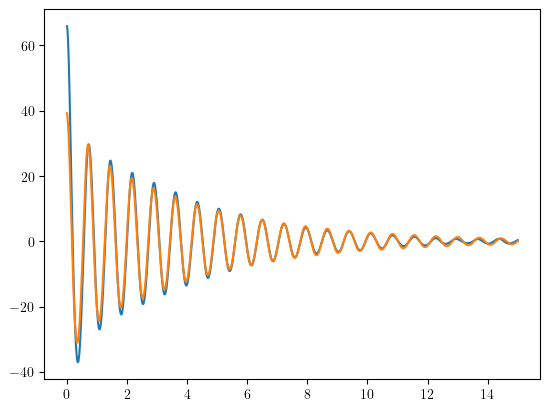

In [22]:
x,y,z = X[:,0] , X[:,1] , X[:,2]
lags, cf = get_acf(z, nlags = nlags,Dt=Dt)
Ckoop = np.array( [np.real(K_corr_proj(lag)) for lag in lags] )
zmin, zmax = data_min[-1] , data_max[-1]
scale = (zmax - zmin) / 2
plt.plot(lags,cf )
plt.plot(lags,Ckoop * scale**2, label = "Koopman")

# Numerical Projections
We compare different projections (Lebesgue, invariant measure, exact) for the evaluation of correlation properties

1.0000000000000027


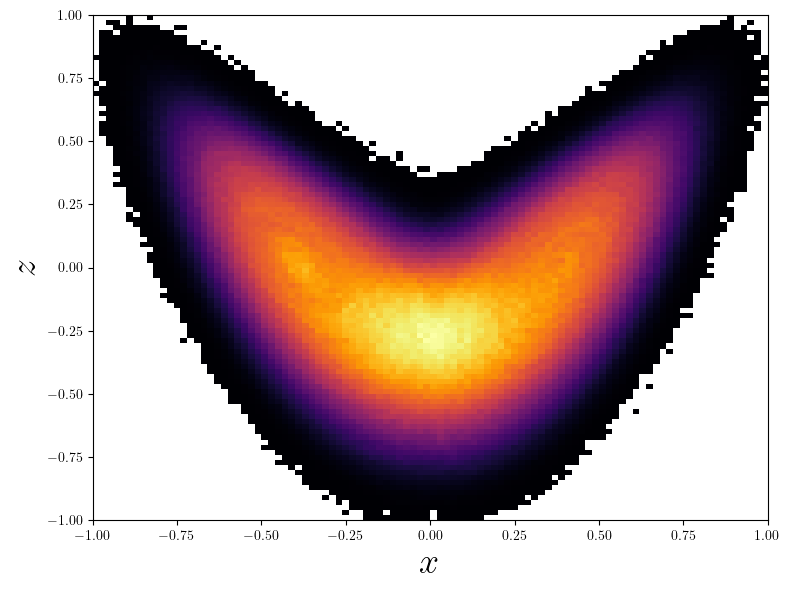

In [ ]:
### EVALUATE INVARIANT MEASURE

lorenz_resp_traj = lorenz63()
lorenz_resp_traj.noise = lorenz.noise
lorenz_resp_traj.tau = 2
lorenz_resp_traj.t_span = (0,100000)

t, X = lorenz_resp_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

L = 100
hist, edges = np.histogramdd(scaled, bins= [int(L)]*3,density=True)
x_centers = 0.5 * (edges[0][1:] + edges[0][:-1])
y_centers = 0.5 * (edges[1][1:] + edges[1][:-1])
z_centers = 0.5 * (edges[2][1:] + edges[2][:-1])

dx = edges[0][1] - edges[0][0]
dy = edges[1][1] - edges[1][0]
dz = edges[2][1] - edges[2][0]
dV = dx * dy * dz

# Build the full grid
Xg, Yg, Zg = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
grid_points = np.stack([Xg.ravel(), Yg.ravel(), Zg.ravel()], axis=1)

# Check the normalisation
print(sum(hist).sum().sum() * dV)

# Compute marginal density in the xz-plane by integrating out y
marginal_xz = np.sum(hist, axis=1) * dy  # integrate over y-axis
marginal_xz[marginal_xz < 1e-4] = np.nan
# Create the meshgrid for plotting
X_plot, Z_plot = np.meshgrid(x_centers, z_centers, indexing="ij")

# Plot the marginal density
plt.figure(figsize=(8, 6))
plt.pcolormesh(X_plot, Z_plot, marginal_xz, shading='auto',cmap="inferno")
plt.xlabel('$x$',size=26)
plt.ylabel('$z$',size=26)
plt.tight_layout()
del X , scaled

In [25]:
# Define an observable on the grid
obs = Zg 

### Projection with Lebesgue

In [26]:
# Evaluate the Gram matrix for Lebesgue products
if 'G_Lebesgue' not in globals():
    Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
    G_Lebesgue = (Psi_Lebesgue.T @ (Psi_Lebesgue * dV)) 
print(np.linalg.cond(G_Lebesgue))

1422.9399770284067


In [27]:
# Project the observable using Lebesgue projections
obs_vals = obs.ravel()
scalar_products = Psi_Lebesgue.T @ (obs_vals * dV)
full_state_coefficients_lebesgue = np.linalg.pinv(G_Lebesgue) @ scalar_products

# If inverting G is problematic, one can regularise it with Truncated Singular Value Decomposition
# U, S, Vt = np.linalg.svd(G_Lebesgue, full_matrices=False) 
# r = np.sum(S > 1e-4 *S[0])
# Ur = U[:,:r] 
# Sr_inv = np.diag(1 / S[:r])
# Gpinv = Ur @ Sr_inv @ Ur.T
#full_state_coefficients_lebesgue = Gpinv @ scalar_products

### Projections with respect to the invariant density

In [28]:
# Thresholding only where the invariant measure is significantly different from zero
hist_flat = hist.ravel()
threshold = np.percentile(hist_flat,94)  
mask = hist_flat >= threshold
relevant_grid_points = grid_points[mask]
hist_vals = hist_flat[mask] 
print(len(hist_vals), threshold)

Psi_Inv_Measure = edmd.evaluate_dictionary_batch(relevant_grid_points)

60957 0.02512562814070345


In [29]:
# Project according to the invariant measure
obs_vals = obs.ravel()[mask]
scalar_products_invariant_measure = Psi_Inv_Measure.T @ (obs_vals * dV * hist_vals)
full_state_coefficients_invariant_measure =  (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.001)) @ tsvd_regulariser.Ur.T  ) @ scalar_products_invariant_measure

In [30]:
# Getting into the reduced r-space
reduced_state_coefficients_lebesgue = tsvd_regulariser.Ur.T @ full_state_coefficients_lebesgue
reduced_state_coefficients_invariant_measure = tsvd_regulariser.Ur.T @ full_state_coefficients_invariant_measure

In [31]:
# Getting into the Koopman space
project_to_koopman_space = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr
koopman_coefficients_lebesgue = project_to_koopman_space @ reduced_state_coefficients_lebesgue
koopman_coefficients_invariant_measure = project_to_koopman_space @ reduced_state_coefficients_invariant_measure

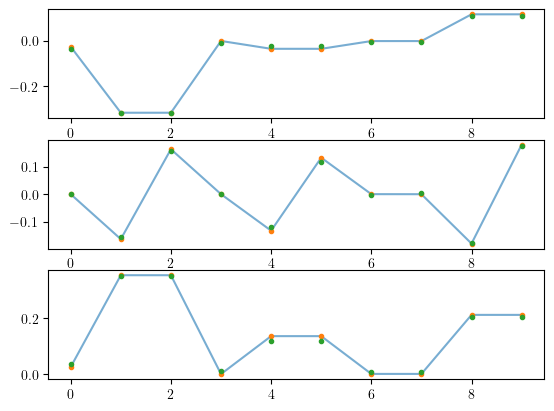

In [32]:
fig, ax = plt.subplots(nrows=3)

ax[0].plot(np.real(fn),alpha=0.6)
ax[0].plot(np.real(koopman_coefficients_lebesgue),'.')
ax[0].plot(np.real(koopman_coefficients_invariant_measure),'.' )

ax[1].plot(np.imag(fn),alpha=0.6)
ax[1].plot(np.imag(koopman_coefficients_lebesgue),'.')
ax[1].plot(np.imag(koopman_coefficients_invariant_measure),'.')

ax[-1].plot(np.abs(fn),alpha=0.6)
ax[-1].plot(np.abs(koopman_coefficients_lebesgue),'.')
ax[-1].plot(np.abs(koopman_coefficients_invariant_measure),'.' )

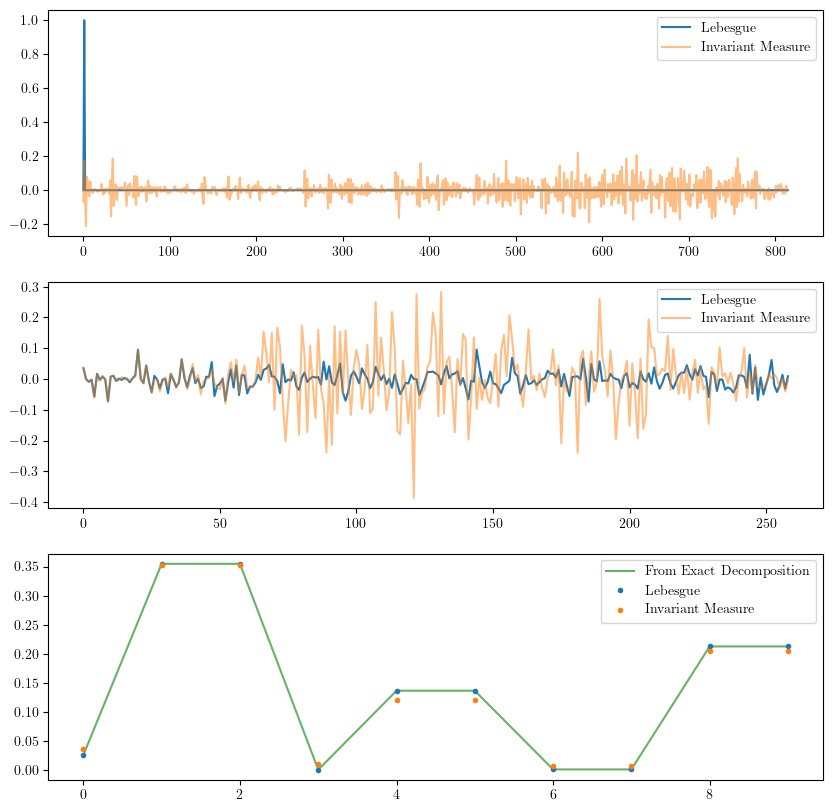

In [33]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(full_state_coefficients_lebesgue,label="Lebesgue")
ax[0].plot(full_state_coefficients_invariant_measure,alpha=0.5,label="Invariant Measure")
ax[0].legend()

ax[1].plot(reduced_state_coefficients_lebesgue,label="Lebesgue")
ax[1].plot(reduced_state_coefficients_invariant_measure,alpha=0.5,label="Invariant Measure")
ax[1].legend()

ax[-1].plot(np.abs(fn),alpha=0.6,color='green',label="From Exact Decomposition")
ax[-1].plot(np.abs(koopman_coefficients_lebesgue),'.',label="Lebesgue")
ax[-1].plot(np.abs(koopman_coefficients_invariant_measure),'.', label="Invariant Measure" )
ax[-1].legend()

#fig.savefig("Projections.png",dpi=600)

In [34]:
koopman_coefficients = {
    "Exact" : fn,
    "Lebesgue": koopman_coefficients_lebesgue,
    "Invariant Measure" : koopman_coefficients_invariant_measure
}

### Effect of taking derivative (in preparation for response)

In [35]:
obs = Zg**2/2

# Projection with Lebesgue
obs_vals = obs.ravel()
scalar_products = Psi_Lebesgue.T @ (obs_vals * dV)
full_state_coefficients_lebesgue = np.linalg.pinv(G_Lebesgue) @ scalar_products

# Projection with Invariant Measure
obs_vals = obs.ravel()[mask]
scalar_products_invariant_measure = Psi_Inv_Measure.T @ (obs_vals * dV * hist_vals)
full_state_coefficients_invariant_measure =  (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.01)) @ tsvd_regulariser.Ur.T  ) @ scalar_products_invariant_measure

In [36]:
###### Taking the derivative #######
# Construct the spectral derivative operator in the full state
Az = edmd.build_derivative_matrix(direction=2)

# Take the normal derivative for Lebesgue projections (the observable is smooth)
derivative_full_state_coefficients_lebesgue = Az @ full_state_coefficients_lebesgue
derivative_reduced_state_coefficients_lebesgue = tsvd_regulariser.Ur.T @ derivative_full_state_coefficients_lebesgue
# Take regularised derivative for Invariant Measure projections
Dr = tsvd_regulariser.Ur.T @ edmd.G @ Az @ tsvd_regulariser.Ur
reduced_state_coefficients_invariant_measure = tsvd_regulariser.Ur.T @ full_state_coefficients_invariant_measure
derivative_reduced_state_coefficients_invariant_measure = np.diag( 1 / (tsvd_regulariser.Sr +0.01)) @ Dr @ reduced_state_coefficients_invariant_measure

# Koopman space
derivative_koopman_coefficients_lebesgue = project_to_koopman_space @ derivative_reduced_state_coefficients_lebesgue
derivative_koopman_coefficients_invariant_measure = project_to_koopman_space @ derivative_reduced_state_coefficients_invariant_measure

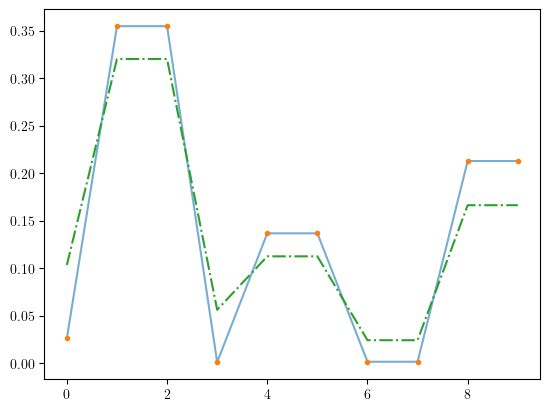

In [37]:
plt.plot(np.abs(koopman_coefficients["Exact"]),alpha=0.6)
plt.plot(np.abs( derivative_koopman_coefficients_lebesgue ),'.')
plt.plot(np.abs(derivative_koopman_coefficients_invariant_measure),'-.')

(-1.0, 15.0)

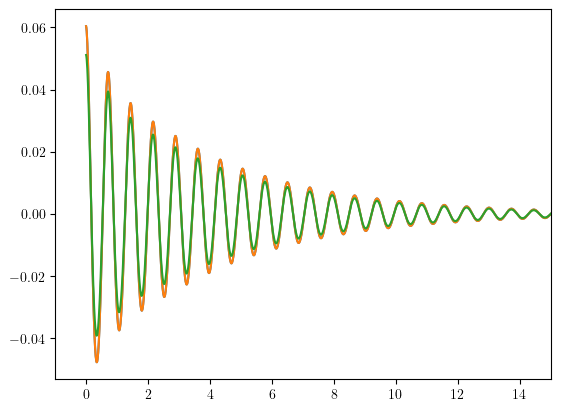

In [38]:
coefficients = [koopman_coefficients["Exact"],derivative_koopman_coefficients_lebesgue,derivative_koopman_coefficients_invariant_measure]
corr_functions = []
for element in coefficients:
    K = lambda t: Koopman_correlation_function(t,G_koop_n,element,element,lambdas_good )
    corr_functions.append([K(lag) for lag in lags])

for corr in corr_functions[0:]:
    plt.plot(lags,np.real(corr))
plt.xlim(-1,15)

In [39]:
# # Normal derivative for the Lebesgue projections
# c1 = edmd.spectral_derivative_tensor_chebyshev_explicit(obs_proj_wSVD_Z2,direction=2)
# obs_proj_wSVD_REDUCED = tsvd_regulariser.Ur.T @ c1

# # Regularised derivative for the projections wrt invariant measure #
# Az = edmd.build_derivative_matrix(direction=2)
# Dr = tsvd_regulariser.Ur.T @ edmd.G @ Az @ tsvd_regulariser.Ur

# obs_proj_inv_measure_REDUCED = sr_inv @  Dr  @ (tsvd_regulariser.Ur.T @ obs_proj_inv_measure_Z2) 

# # # # From projected, to full again, derive and then re-project
# c_tilde = tsvd_regulariser.Ur.T @ obs_proj_inv_measure_Z2
# c_full = tsvd_regulariser.Ur @ (sr_inv @ c_tilde)


# fn_wSVD = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr @ obs_proj_wSVD_REDUCED
# fn_wSVD_inv_measure = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr @ obs_proj_inv_measure_REDUCED

# # # plt.plot(obs_proj_wSVD_REDUCED)
# # # plt.plot(obs_proj_inv_measure_REDUCED)


# plt.plot(np.abs(fn_wSVD) )
# plt.plot(np.abs(fn_wSVD_inv_measure))

### Response with projection of $\Gamma$ with respect to the invariant measure 

In [40]:
# Thresholding only where the invariant measure is significantly different from zero
hist_flat = hist.ravel()
threshold = np.percentile(hist_flat,95)  
mask = hist_flat >= threshold
relevant_grid_points = grid_points[mask]
hist_vals = hist_flat[mask] 
print(len(hist_vals), threshold)

Psi_Inv_Measure = edmd.evaluate_dictionary_batch(relevant_grid_points)

50179 0.06281407035175932


In [41]:
obs = - Xg * hist
obs_vals = obs.ravel()[mask]

scalar_products_invariant_measure = Psi_Inv_Measure.T @ (obs_vals * dV )
full_state_coefficients_invariant_measure =  (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr+0.01)) @ tsvd_regulariser.Ur.T  ) @ scalar_products_invariant_measure

In [42]:
Ay = edmd.build_derivative_matrix(direction=1)
# Take regularised derivative for Invariant Measure projections
Dr = tsvd_regulariser.Ur.T @ edmd.G @ Ay @ tsvd_regulariser.Ur
reduced_state_coefficients_invariant_measure = tsvd_regulariser.Ur.T @ full_state_coefficients_invariant_measure
derivative_reduced_state_coefficients_invariant_measure = np.diag( 1 / (tsvd_regulariser.Sr + 0.01) ) @ Dr @ reduced_state_coefficients_invariant_measure
derivative_koopman_coefficients_invariant_measure = project_to_koopman_space @ derivative_reduced_state_coefficients_invariant_measure

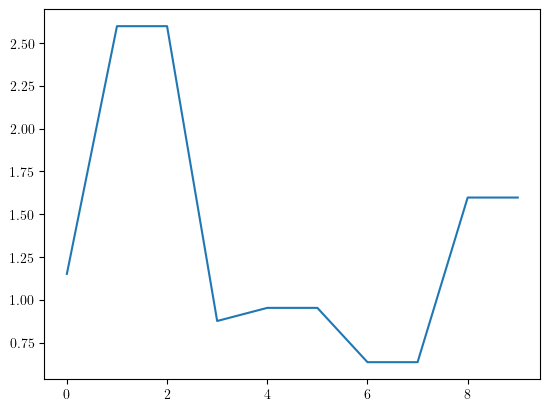

In [43]:
plt.plot(np.abs(derivative_koopman_coefficients_invariant_measure))

(-1.0, 15.0)

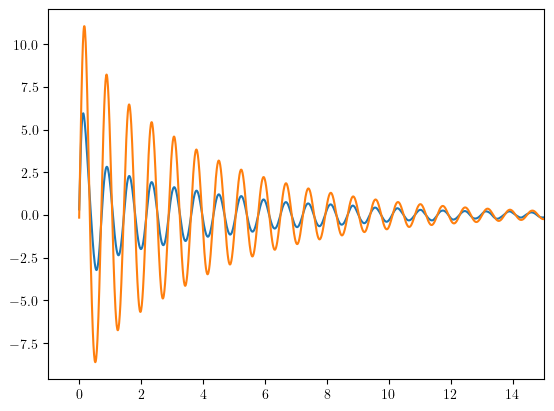

In [45]:
Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,derivative_koopman_coefficients_lebesgue,derivative_koopman_coefficients_invariant_measure,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )


# zmax = data_max[-1]
# zmin = data_min[-1]
# scale = (zmax - zmin) / 2 

f_name = "GREEN_FUNCTION.pkl"
with open(data_path/f_name,"rb") as f:
    G = pickle.load(f)

tresp = G["t"]
G = G["Green Function"]

plt.plot(tresp,G)
plt.plot(lags,Gkoop *scale) 
plt.xlim(-1,15)

In [46]:
### From time series
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 5
lorenz_cf_traj.t_span = (0,50000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 10000000/10000000 [01:28<00:00, 113087.89it/s]


In [47]:
batch_size = 100_000
n_total = scaled.shape[0]
range_batches = range(0, n_total, batch_size)
n_batches = len(range_batches)

# Optional: get output shape from one batch
example = edmd.evaluate_dictionary_batch(scaled[:1, :])
avgs = np.zeros(example.shape[1])

for i in tqdm(range_batches):
    batch = scaled[i:min(i + batch_size, n_total), :]
    Psi_trajectory = edmd.evaluate_dictionary_batch(batch)
    x_traj = batch[:, 0]
    avgs += np.mean(x_traj[:, None] * Psi_trajectory, axis=0)

avgs /= n_batches


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [48]:
# Thresholding on a subset of modes
tau_threshold = -1.5
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]

# Projection onto the subspace spanned by the leading n selected modes
Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
G_koop_n = Vn.T.conj() @ Gr @ Vn
project_to_koopman_space = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr
fn =  project_to_koopman_space @ projections_reduced

In [49]:
# Working in full space
scalar_product_Gamma = Ay.T @ avgs
Gamma_projections = (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.01)) @ tsvd_regulariser.Ur.T  ) @ scalar_product_Gamma
reduced_Gamma = tsvd_regulariser.Ur.T @ Gamma_projections
koopman_Gamma = project_to_koopman_space @ reduced_Gamma

# Working just in reduced space
reduced_der_operator = tsvd_regulariser.Ur.T @ Ay.T @ tsvd_regulariser.Ur
reduced_delta = tsvd_regulariser.Ur.T @ avgs
reduced_Gamma_2 = np.diag( 1 / (tsvd_regulariser.Sr + 0.05 )) @ reduced_der_operator @ reduced_delta
koopman_Gamma_2 = project_to_koopman_space @ reduced_Gamma_2

# Derivative operator in Koopman
P_koop = Vn @ project_to_koopman_space


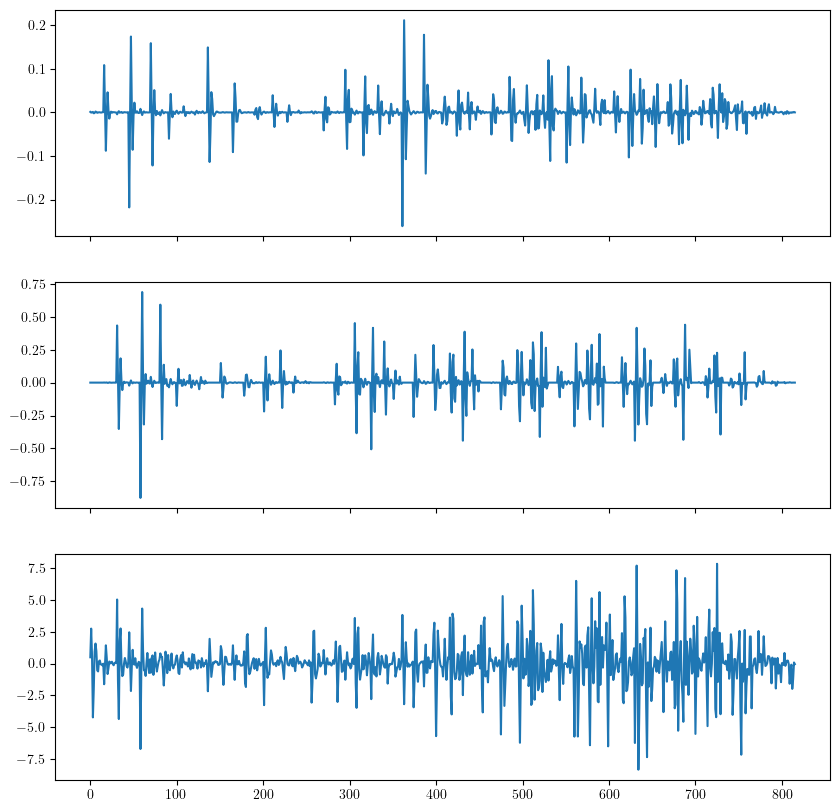

In [50]:
fig , ax = plt.subplots(nrows=3,sharex=True,figsize= (10,10))
ax[0].plot(avgs)
ax[1].plot(scalar_product_Gamma)
ax[2].plot(Gamma_projections)

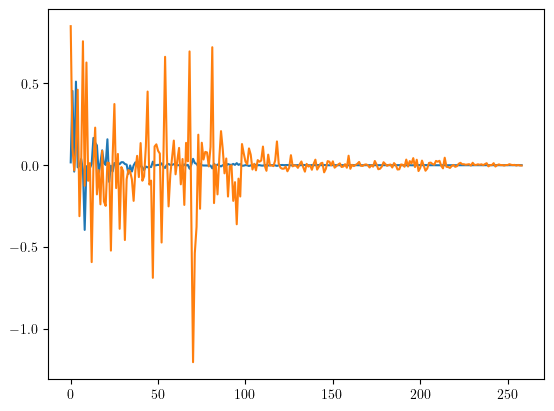

In [51]:
plt.plot(reduced_delta)
plt.plot(reduced_der_operator @ reduced_delta)

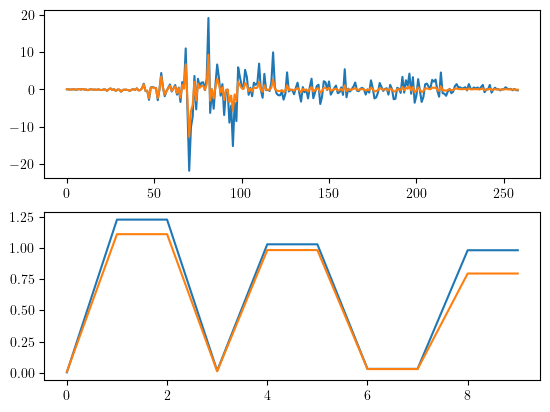

In [52]:
fig, ax  = plt.subplots(nrows=2)
ax[0].plot(reduced_Gamma)
ax[0].plot(reduced_Gamma_2)
ax[1].plot(np.abs(koopman_Gamma))
ax[1].plot(np.abs(koopman_Gamma_2))

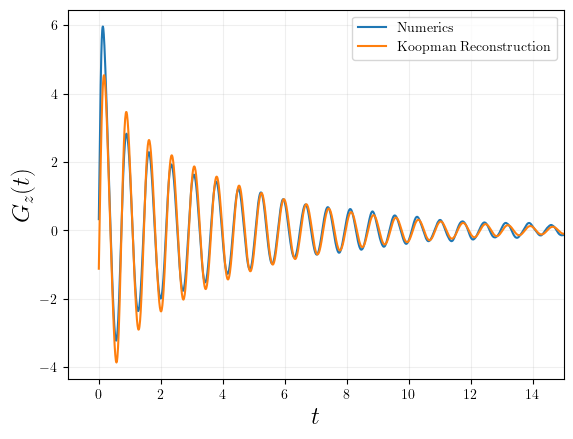

In [53]:
Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn,koopman_Gamma_2,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )
plt.plot(tresp,G,label="Numerics")
plt.plot(lags,Gkoop*scale, label="Koopman Reconstruction") 
plt.xlim(-1,15)
plt.grid('--',alpha=0.2)
plt.xlabel("$t$",size=18)
plt.ylabel("$G_z(t)$",size=18)
plt.legend()
#plt.savefig("Koopman_Reconstruction_Green_Function.png",dpi=500)

### Let's do the $\Gamma$ first

In [54]:
# Psi_Lebesgue_masked = edmd.evaluate_dictionary_batch(data)
# rho0 = hist_flat[mask]
# x_vals = data[:, 0]
# Gamma_internal = - x_vals * np.log(rho0)

# # Projection w/ Lebesgue
# rhs = Psi_Lebesgue_masked.T @ (Gamma_internal * dV)
# obs_proj = Gpinv @ rhs # with Lebesgue measure

# # # Projection w/ Inv Measure
# # rhs = Psi_Lebesgue_masked.T @ (Gamma_internal * dV * rho0)
# # sr_inv = np.diag( 1 / tsvd_regulariser.Sr)
# # obs_proj = ( tsvd_regulariser.Ur @ sr_inv @ tsvd_regulariser.Ur.T ) @ rhs_inv_measure

In [55]:
# Gamma_coeffs = edmd.spectral_derivative_tensor_chebyshev_explicit(obs_proj,direction=1)
# Gamma_reduced = tsvd_regulariser.Ur.T @ Gamma_coeffs
# Gamma_koop = np.linalg.pinv(Mn) @ Vn.conj().T @ Gr @ Gamma_reduced

In [56]:
# Gkoop = lambda t: Koopman_correlation_function(t,Mn,fn,Gamma_koop ,lambdas_good )
# Gkoop = np.array( [np.real( Gkoop(lag) )for lag in lags] )



In [57]:
# zmax = data_max[-1]
# zmin = data_min[-1]
# scale = (zmax - zmin) / 2 

In [58]:
# plt.plot(t,G  )
# plt.plot(lags,Gkoop  )
# plt.xlim(-1,15)

### Let's try with $\gamma$ (old method)

In [59]:
# rho0 = hist_flat
# x_vals = grid_points[:,0]
# gamma = - x_vals * rho0
# rhs = Psi_Lebesgue.T @ (gamma * dV)
# obs_proj = Gpinv @ rhs # with Lebesgue measure
# gamma_coeffs = edmd.spectral_derivative_tensor_chebyshev_explicit(obs_proj,direction=1)

# W = tsvd_regulariser.reduced_left_eigvecs
# V = tsvd_regulariser.reduced_right_eigvecs

# gamma_proj = W.T.conj() @ tsvd_regulariser.Ur.T @gamma_coeffs
# MLebesgue = V.T.conj() @ (tsvd_regulariser.Ur.T @ G_Lebesgue @ tsvd_regulariser.Ur ) @ V

# # gamma_der_reduced_projections = tsvd_regulariser.Ur.T@ gamma_coeffs
# # Gr_Lebesgue = tsvd_regulariser.Ur.T @ G_Lebesgue @ tsvd_regulariser.Ur

# # Mn_Lebesgue = Vn.T.conj() @ Gr_Lebesgue @ Vn
# # gamma_der_koopman_projections = np.linalg.pinv(Mn_Lebesgue) @ Vn.conj().T @ Gr_Lebesgue @ gamma_der_reduced_projections

# G_koop_gamma = lambda t: Koopman_correlation_function(t,MLebesgue[:len(fn),:len(fn)],fn ,gamma_proj[:len(fn)] ,lambdas[:len(fn)] )
# G_gamma = np.array( np.real(  [G_koop_gamma(lag) for lag in lags] ))